Implement the Dantzig-Fulkerson-Johnson model for the TSP, using callbacks.
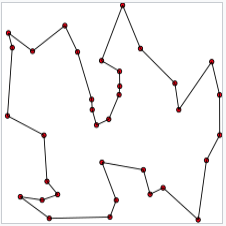

In [1]:
import networkx as nx

n = 20                     # number of cities
G = nx.complete_graph(20)  # graph with a vertex for each city

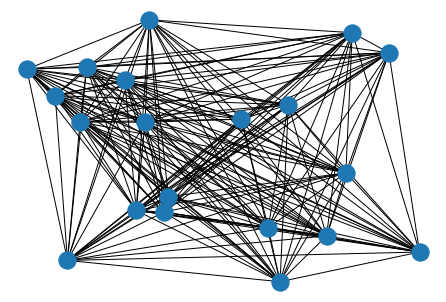

In [2]:
# for convenience, pick the city (x,y)-coordinates at random
import random

my_pos = { i : ( random.random(), random.random() ) for i in G.nodes } # pos[i] = (x_i, y_i)
nx.draw(G, pos=my_pos)

In [3]:
# for convenience, suppose that distances are Euclidean
import math
def eucl_dist(x1,y1,x2,y2):
    return math.sqrt( (x1-x2)**2 + (y1-y2)**2 )

for i,j in G.edges:
    (x1,y1) = my_pos[i]
    (x2,y2) = my_pos[j]
    G.edges[i,j]['length'] = eucl_dist(x1,y1,x2,y2)

In [4]:
import gurobipy as gp
from gurobipy import GRB

In [5]:
# Start with the 2-matching relaxation

m = gp.Model()
x = m.addVars( G.edges, vtype=GRB.BINARY )

m.setObjective( gp.quicksum( G.edges[i,j]['length'] * x[i,j] for i,j in G.edges ), GRB.MINIMIZE )

# Each city should touch the tour twice (enter-and-leave)
m.addConstrs( gp.quicksum( x[e] for e in G.edges if e in G.edges(i) ) == 2 for i in G.nodes )

m.update()

Set parameter Username
Academic license - for non-commercial use only - expires 2023-01-01


In [6]:
# create a function to separate the subtour elimination constraints
def subtour_elimination(m, where):
    
    # check if LP relaxation at this branch-and-bound node has an integer solution
    if where == GRB.Callback.MIPSOL: 
        
        # retrieve the LP solution
        xval = m.cbGetSolution(m._x)
        
        # which edges are selected?
        tour_edges = [ e for e in m._G.edges if xval[e] > 0.5 ]
        
        # for each subtour, add a constraint
        for component in nx.connected_components( m._G.edge_subgraph( tour_edges ) ):
            
            if len(component) < m._G.number_of_nodes():
                
                inner_edges = [ (i,j) for (i,j) in m._G.edges if i in component and j in component ]
                m.cbLazy( gp.quicksum( m._x[e] for e in inner_edges ) <= len(component) - 1 )
    

In [7]:
# tell Gurobi that we will be adding (lazy) constraints
m.Params.lazyConstraints = 1

# designate the callback routine to be subtour_elimination()
m._callback = subtour_elimination

# add the variables and graph to our model object, for use in the callback
m._x = x
m._G = G

# solve the MIP with our callback
m.optimize(m._callback)

Set parameter LazyConstraints to value 1
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 20 rows, 190 columns and 380 nonzeros
Model fingerprint: 0x4c040c8b
Variable types: 0 continuous, 190 integer (190 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Presolve time: 0.00s
Presolved: 20 rows, 190 columns, 380 nonzeros
Variable types: 0 continuous, 190 integer (190 binary)

Root relaxation: objective 4.054069e+00, 35 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       4.0787227    4.07872  0.00%     -    0s

Cutting planes:
  Lazy constraints: 11

Explored 1 nodes (37 simplex iterations) in 0

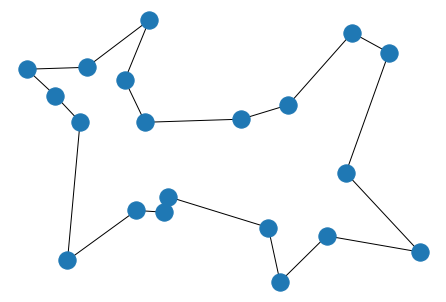

In [8]:
# get the solution and draw it
tour_edges = [ e for e in G.edges if x[e].x > 0.5 ]
nx.draw(G.edge_subgraph(tour_edges), pos=my_pos)